### This solution notebook is not yet finished and things do not work yet as they should. 

### Task 1

Since there is only one set of constraints it is not difficult to choose which constraints to relax.
$$
\begin{aligned}
z_{LB}=\min &\sum_{j=1}^n[c_j - \sum_{i=1}^n \lambda_i a_{ij}]x_j + \sum^n_{j=1}\lambda_i\\
&x_j\in \{0,1\} \qquad j=1,...,n 
\end{aligned}
$$

Defining $C_j = [c_j - \sum_{i=1}^m \lambda_i a_{ij}]$ $j=1,...,n$
i.e. $C_j$ is the coefficient of $x_j$ in the objective function of LR we have that LR becomes:
$$
\begin{aligned}
z_{LB}=\min &\sum_j(C_jx_j + \lambda_i)\\
& x_j\in \{0,1\} \qquad j=1,...,n 
\end{aligned}
$$

Now the solution $x_j$ to LR can be found by inspection, namely: 
$$
x_j=
\begin{cases}
 1 &if C_j \leq 0\\
  0 &\text{otherwise}
\end{cases}
$$
with the solution value $z_{LB}$ of LR being given by:
$$z_{LB} = C_jx_j + \lambda_i$$
where $z_{LB}$ is a lower bound on the optimal solution to the original SCP. 

In [83]:
import numpy as np
import pyomo.environ as po

c = np.array([ 2,3,4,5 ])
b = np.array([1,1,1])
A = np.array([[1, 0, 1, 0 ],
              [1, 0, 0, 1],
              [0, 1, 1, 1]])

def solve_SCP(vtype=po.Binary):
    # Model
    model = po.ConcreteModel("SCP")
    # Create decision variables
    model.x = po.Var(range(4), bounds=(0,1), domain=vtype)
  
    # The objective is to minimize
    model.z = po.Objective(expr=sum(c[i]*model.x[i] for i in range(4)), sense=po.minimize)
    # Add constraints to the model
    model.c1 = po.Constraint(expr=model.x[0] + model.x[2] >= 1)
    model.c2 = po.Constraint(expr=model.x[0] + model.x[3] >= 1)
    model.c3 = po.Constraint(expr=model.x[1] + model.x[2] + model.x[3] >= 1)
    # Solve
    solver = po.SolverFactory('glpk')
    results = solver.solve(model)
    
    # Let’s print the solution
    if results.Solver.status == po.SolverStatus.ok:
        x = [v() for v in model.component_data_objects(po.Var, active=True)]
        return x, model.z()
    else:
        print("Problem could not be solved to optimality")

In [84]:
solve_SCP()

([1.0, 1.0, 0.0, 0.0], 5.0)

In [85]:
solve_SCP(vtype=po.Reals)

([1.0, 1.0, 0.0, 0.0], 5.0)

In [111]:
def solve_lagrangian(lambdas):
    print("solve with lambda: ",lambdas)
    C = c - lambdas * A[2,:]
    # Model
    model = po.ConcreteModel("LR")
    # Create decision variables
    model.x = po.Var(range(4), bounds=(0,1), domain=po.Binary)

    model.z_LR = po.Objective(expr=sum(C[i]*model.x[i] for i in range(4))+sum(lambdas), sense=po.minimize)
    # Add constraints to the model
    model.c1 = po.Constraint(expr=model.x[0] + model.x[2] >= 1)
    model.c3 = po.Constraint(expr=model.x[1] + model.x[2] + model.x[3] >= 1)

    # Solve
    solver = po.SolverFactory('glpk')
    results = solver.solve(model)
    
    # Let’s print the solution
    if results.Solver.status == po.SolverStatus.ok:
        x_LR = [v() for v in model.component_data_objects(po.Var, active=True)]
        return x_LR, model.z_LR()
    else:
        print("Problem could not be solved to optimality")

In [86]:
solve_lagrangian(1.5)

solve with lambda:  1.5


([0.0, 0.0, 1.0, 0.0], 4.0)

### Task 2

A common fallacy in Lagrangean relaxation is to believe that, if the solution to LR
is feasible for the original problem, then it is also optimal for the original problem.
This is incorrect. 

In [40]:
solve_lagrangian(lambdas=1)

([0.0, 0.0, 1.0, 0.0], 4.0)

In [93]:
x, z_LR = solve_lagrangian(lambdas=0)

solve with lambda:  0


A solution $x$ to a Lagrangean lower bound program is only optimal for the
original problem if:

1. $x$ is feasible for the original problem; and

2. $cx = [cX + \lambda(b - AX)]$ i.e. $\lambda(b - Ax) = 0$

If we are relaxing equality
constraints ($Ax=b$) then any solution to the lagrangean lower bound program which is
feasible for the original problem automatically satisfies both 1. and 2. above and so is
optimal. 

### Task 4

In [102]:
def heuristic_sol(x):
    x_h=np.copy(x)
    covered = A @ x_h-b >= 0
    for i in range(len(covered)):
        if not covered[i]:
            for j in range(len(A[i,:])):
                if A[i,j] >0:
                    x_h[j]=1
                    break
    z_UB = c @ x_h
    #print(x_h,z_UB)
    return z_UB

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt

def solve_lagrangian_dual(mu=2, iterations=10):
    zs_LR=[]
    zs_LB=[]
    zs_UB=[]
    z_best_LB=-1000
    lambdas_ = []
    lambdas = np.array([0])
    for t in range(iterations):
        x, z_LR = solve_lagrangian(lambdas)
        if z_best_LB<z_LR:
            z_best_LB=z_LR
        z_UB = heuristic_sol(x)
        gamma = np.array([b[1] - A[1,:] @ x])
        print(gamma)
        theta = mu * ( z_UB - z_LR )/(sum(gamma**2))
        for i in range(len(lambdas)):
            if (gamma[i]>0.1):                
                lambdas[i] = max(lambdas[i] + theta * gamma[i], 0)
        zs_UB.append(z_UB); zs_LR.append(z_LR); zs_LB.append(z_best_LB); lambdas_.append(lambdas)
    
    plt.subplot(3, 1, 1)
    plt.plot(range(iterations), zs_LR, 'o-')
    plt.ylabel('z_LR')
    plt.xlabel('iteration')

    plt.subplot(3, 1, 2)
    plt.plot(range(iterations), zs_LB, 'o-')
    plt.ylabel('z_LB')
    plt.xlabel('iteration')
    
    plt.subplot(3, 1, 3)
    plt.plot(range(iterations), lambdas_, 'o-')
    plt.xlabel('iteration')
    plt.ylabel('lambda')

In [104]:
A[2,:]

array([0, 1, 1, 1])

solve with lambda:  [0]
[1.]
solve with lambda:  [4]
[1.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


[0.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]
[0.]
solve with lambda:  [16]
[0.]


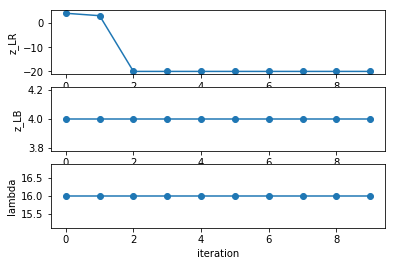

In [123]:
solve_lagrangian_dual()

# Task 2

We consider the following problem (Fisher M., [An Applications Oriented
Guide to Lagrangian Relaxation](http://www.cs.uleth.ca/~benkoczi/OR/read/lagrange-relax-introduct-fisher85.pdf) Interfaces, 15:2, 1985):

$$
\begin{array}{lllll}
 z_P=&\text{max} &16x_1+10x_2+4x_4\\
&\text{s.t.}&8x_1+2x_2+x_3+x_4\leq 10\\
&&x_1+x_2\leq 1\\
&&x_3+x_4\leq 1\\
&&0\leq x\leq 1 \qquad \text{and integer}
\end{array}
$$

There are three major questions to design a Lagrangian-relaxation-based system:
a. which constraints should be relaxaed
b. how to compute good multipliers $\lambda$
c. how to deduce a good feasible solution to the original problem, given a solution to the Lagrangian relaxation problem.

The answers are:
a. those whose relaxation makes the problem significantly easy but not too easy
b. subgradient procedure
c. problem specific heuristics


## Subtask 2.1
If we relax the first constraint with multiplier $\lambda\geq 0$ the corresponding Lagrangian relaxation problem becomes:

$$
\begin{array}{lllll}
 z_P=&\text{max} &(16-8\lambda)x_1+(10-2\lambda)x_2+(0-\lambda)x_3+(4-4\lambda)x_4+10\lambda\\
&\text{s.t.}&x_1+x_2\leq 1\\
&&x_3+x_4\leq 1\\
&&0\leq x\leq 1 \qquad \text{and integer}
\end{array}
$$


For a given $\lambda$ we could solve the problem by inspection: 
- between $x_1$ and $x_2$ set to 1 the variable with the largest cost coefficient in the objective function; 
- between $x_1$ and $x_2$ set to 1 the variable with the largest cost coefficient in the objective function.
However let's use the SCIP procedure developed above.

In [68]:
import numpy as np
import pyomo.environ as po


c = np.array([ 16,10,0,4 ])
b = np.array([10,1,1])
A = np.array([[ 8, 2, 1, 4 ],
            [1, 1, 0, 0],
            [0, 0, 1, 1]])

def solve(vtype=po.Binary):
    # Model
    model = po.ConcreteModel("Original")
    # Create decision variables
    model.x = po.Var(range(4), bounds=(0,1), domain=po.Reals)
  
    # The objective is to minimize
    model.z = po.Objective(expr=sum(c[j]*model.x[j] for j in range(4)), sense=po.maximize)
    # Add constraints to the model
    model.constraints = po.ConstraintList()
    for i in range(3):
        model.constraints.add(expr=sum(A[i,j]*model.x[j] for j in range(4)) <= b[i])
    
    model.pprint()
    # Solve
    solver = po.SolverFactory('glpk')
    results = solver.solve(model, tee=True)
    
    # Let’s print the solution
    if results.Solver.status == po.SolverStatus.ok:
        x = [v() for v in model.component_data_objects(po.Var, active=True)]
        return x, model.z()
    else:
        print("Problem could not be solved to optimality")



In [69]:
solve(po.Reals)

2 Set Declarations
    constraints_index : Dim=0, Dimen=1, Size=3, Domain=None, Ordered=False, Bounds=None
        [1, 2, 3]
    x_index : Dim=0, Dimen=1, Size=4, Domain=None, Ordered=False, Bounds=(0, 3)
        [0, 1, 2, 3]

1 Var Declarations
    x : Size=4, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True :  Reals
          1 :     0 :  None :     1 : False :  True :  Reals
          2 :     0 :  None :     1 : False :  True :  Reals
          3 :     0 :  None :     1 : False :  True :  Reals

1 Objective Declarations
    z : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 16*x[0] + 10*x[1] + 4*x[3]

1 Constraint Declarations
    constraints : Size=3, Index=constraints_index, Active=True
        Key : Lower : Body                            : Upper : Active
          1 :  -Inf : 8*x[0] + 2*x[1] + x[2] + 4*x[3] :  10.0 :   True
          2 :

([1.0, 0.0, 0.0, 0.5], 18.0)